真值推断图2没有恶意用户没有资格评估

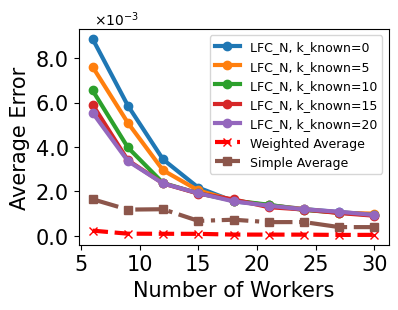

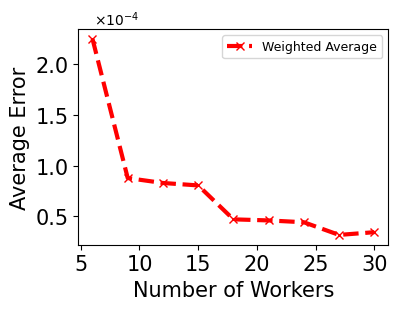

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100]  # Standard deviations for three user types
error_threshold = 0.0001




def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = [np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)) for std_dev in std_devs]
    #datas = np.round([np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)) for std_dev in std_devs], 9)
    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean

ms = [6, 9, 12, 15, 18, 21, 24, 27, 30]
known_values = [0, 5, 10, 15, 20]

line_width = 3
label_font_size = 15
legend_font_size = 9
tick_font_size = 15
marker_size = 6
plt.figure(figsize=(4, 2.8))

# Loop through known values and 'ms' for LFC_N method
for k_known in known_values:
    k = beta - k_known
    average_errors = []
    for m in ms:
        errors = []
        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(t, std_devs, m, k_known)
            error = LFC_N(data, known_data, m)
            errors.append(error)
        average_errors.append(np.mean(errors))
    plt.plot(ms, average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}', linewidth=line_width, markersize=marker_size)


# Compute errors for weighted_average, simple_average, and mode
weighted_average_errors = []
simple_average_errors = []
mode_errors = []
for m in ms:
    errors_weighted = []
    errors_simple = []
    errors_mode = []
    for _ in range(100):
        data = generate_data(mean, std_devs, m, 30)

        # Weighted average
        weighted_mean = weighted_average(data)
        errors_weighted.append((weighted_mean - mean)**2)

        # Simple average
        simple_mean = np.mean(data)
        errors_simple.append((simple_mean - mean)**2)

        # Mode
        flattened_data = data.flatten()
        mode = stats.mode(flattened_data).mode
        errors_mode.append((mode - mean)**2)

    weighted_average_errors.append(np.mean(errors_weighted))
    simple_average_errors.append(np.mean(errors_simple))
    mode_errors.append(np.mean(errors_mode))

# Plotting the errors for additional methods
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, color='red', markersize=marker_size)
plt.plot(ms, simple_average_errors, marker='s', linestyle='-.', label='Simple Average', linewidth=line_width, markersize=marker_size)
#plt.plot(ms, mode_errors, marker='v', linestyle=':', label='Mode')

plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
# 应用 ScalarFormatter 到 y 轴
def custom_formatter(value, pos):
    return "{:.1f}".format(value*1000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# 启用科学记数法并设置显示指数的条件
plt.ylabel('Average Error', fontsize=label_font_size)
plt.gca().annotate('$\\times10^{-3}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')

# 保存第一张图
plt.savefig('/content/drive/MyDrive/实验图/图2a.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# 绘制第二张图 - 只展示“Weighted Average”方法
plt.figure(figsize=(4, 2.8))
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, color='red', markersize=marker_size)
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*10000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)


plt.gca().annotate('$\\times10^{-4}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')


plt.savefig('/content/drive/MyDrive/实验图/图2b.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


图3随着次数变化

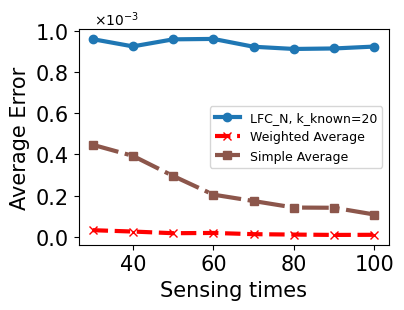

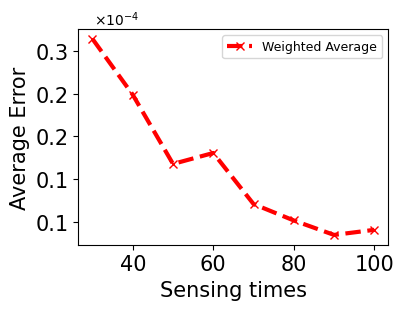

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100]  # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = [np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)) for std_dev in std_devs]
    #datas = np.round([np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)) for std_dev in std_devs], 9)
    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean

# ... [import statements and function definitions remain unchanged]

ms = [30]  # Fixed value of m to 30
betas = list(range(30, 101, 10))  # Values of beta from 30 to 100 in steps of 10
known_values = [20]  # Fixed value of k_known to 20


plt.figure(figsize=(4, 2.8))

# Loop through betas, known values and 'ms' for LFC_N method
all_average_errors = []

# Loop through betas, known values and 'ms' for LFC_N method
for beta in betas:
    for k_known in known_values:
        k = beta - k_known
        average_errors = []
        for m in ms:
            errors = []
            for _ in range(100):
                data = generate_data(mean, std_devs, m, k)
                known_data = generate_data(t, std_devs, m, k_known)
                error = LFC_N(data, known_data, m)
                errors.append(error)
            average_errors.append(np.mean(errors))
        all_average_errors.append(np.mean(average_errors))

# Now plot all_average_errors against betas
plt.plot(betas, all_average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={known_values[0]}', linewidth=line_width, markersize=marker_size)

# Compute errors for weighted_average, simple_average, and mode
weighted_average_errors = []
simple_average_errors = []
mode_errors = []
for beta in betas:
    errors_weighted = []
    errors_simple = []
    errors_mode = []
    for _ in range(100):
        data = generate_data(mean, std_devs, m, beta)

        # Weighted average
        weighted_mean = weighted_average(data)
        errors_weighted.append((weighted_mean - mean)**2)

        # Simple average
        simple_mean = np.mean(data)
        errors_simple.append((simple_mean - mean)**2)

        # Mode
        flattened_data = data.flatten()
        mode = stats.mode(flattened_data).mode
        errors_mode.append((mode - mean)**2)

    weighted_average_errors.append(np.mean(errors_weighted))
    simple_average_errors.append(np.mean(errors_simple))
    mode_errors.append(np.mean(errors_mode))

# Plotting the errors for additional methods
plt.plot(betas, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, color='red', markersize=marker_size)
plt.plot(betas, simple_average_errors, marker='s', linestyle='-.', label='Simple Average',linewidth=line_width,  color='#8c564b',markersize=marker_size)

plt.xlabel('Sensing times', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*1000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-3}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图3a.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(4, 2.8))
plt.plot(betas, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, color='red', markersize=marker_size)
plt.xlabel('Sensing times', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*10000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-4}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图3b.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

图4有随性的恶意用户

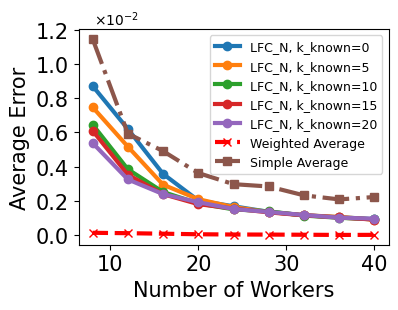

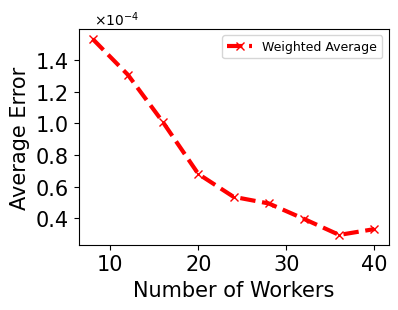

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform'] # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform':
            datas.append(np.random.uniform(0, 10, (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))

    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean

ms = [8, 12, 16, 20, 24, 28, 32, 36, 40]
known_values = [0, 5, 10, 15, 20]

plt.figure(figsize=(4, 2.8))

# Loop through known values and 'ms' for LFC_N method
for k_known in known_values:
    k = beta - k_known
    average_errors = []
    for m in ms:
        errors = []
        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(t, std_devs, m, k_known)
            error = LFC_N(data, known_data, m)
            errors.append(error)
        average_errors.append(np.mean(errors))
    plt.plot(ms, average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}',linewidth=line_width, markersize=marker_size)

# Compute errors for weighted_average, simple_average, and mode
weighted_average_errors = []
simple_average_errors = []
mode_errors = []
for m in ms:
    errors_weighted = []
    errors_simple = []
    errors_mode = []
    for _ in range(100):
        data = generate_data(mean, std_devs, m, 30)

        # Weighted average
        weighted_mean = weighted_average(data)
        errors_weighted.append((weighted_mean - mean)**2)

        # Simple average
        simple_mean = np.mean(data)
        errors_simple.append((simple_mean - mean)**2)

        # Mode
        flattened_data = data.flatten()
        mode = stats.mode(flattened_data).mode
        errors_mode.append((mode - mean)**2)

    weighted_average_errors.append(np.mean(errors_weighted))
    simple_average_errors.append(np.mean(errors_simple))
    mode_errors.append(np.mean(errors_mode))

# Plotting the errors for additional methods
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, markersize=marker_size, color='red')
plt.plot(ms, simple_average_errors, marker='s', linestyle='-.', label='Simple Average',linewidth=line_width, markersize=marker_size)
#plt.plot(ms, mode_errors, marker='v', linestyle=':', label='Mode')

# Finalizing plot
plt.xlabel('Number of Workers',fontsize=label_font_size)
plt.ylabel('Average Error',fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图4a.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(4, 2.8))
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, markersize=marker_size, color='red')
plt.xlabel('Number of Workers',fontsize=label_font_size)
plt.ylabel('Average Error',fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*10000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-4}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图4b.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



图5有思考后的恶意用户

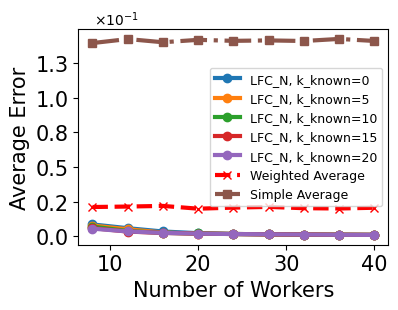

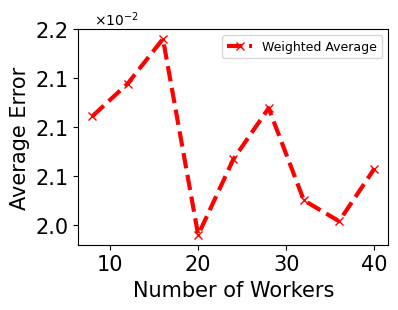

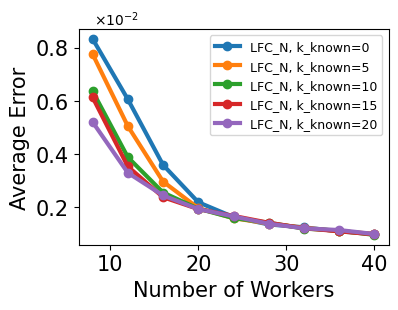

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform'] # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform':
            datas.append(np.random.uniform(6, 7 , (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))

    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean

ms = [8, 12, 16, 20, 24, 28, 32, 36, 40]
known_values = [0, 5, 10, 15, 20]

# 计算 Weighted Average 和 Simple Average 的错误
weighted_average_errors = []
simple_average_errors = []
for m in ms:
    errors_weighted = []
    errors_simple = []
    for _ in range(100):
        data = generate_data(mean, std_devs, m, 30)
        weighted_mean = weighted_average(data)
        simple_mean = np.mean(data)
        errors_weighted.append((weighted_mean - mean)**2)
        errors_simple.append((simple_mean - mean)**2)

    weighted_average_errors.append(np.mean(errors_weighted))
    simple_average_errors.append(np.mean(errors_simple))



# 第一张图
plt.figure(figsize=(4, 2.8))
for k_known in known_values:
    k = beta - k_known
    average_errors = []
    for m in ms:
        errors = []
        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(t, std_devs, m, k_known)
            error = LFC_N(data, known_data, m)
            errors.append(error)
        average_errors.append(np.mean(errors))
    plt.plot(ms, average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}', linewidth=line_width,markersize=marker_size)
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, color='red',markersize=marker_size)
plt.plot(ms, simple_average_errors, marker='s', linestyle='-.', label='Simple Average', linewidth=line_width,markersize=marker_size)
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*10)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-1}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图5a.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()


# 第二张图
plt.figure(figsize=(4, 2.8))
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average', linewidth=line_width, color='red',markersize=marker_size)
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图5b.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()


# 第三张图
plt.figure(figsize=(4, 2.8))
for k_known in known_values:
    k = beta - k_known
    average_errors = []
    for m in ms:
        errors = []
        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(t, std_devs, m, k_known)
            error = LFC_N(data, known_data, m)
            errors.append(error)
        average_errors.append(np.mean(errors))
    plt.plot(ms, average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}', linewidth=line_width,markersize=marker_size)
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图5c.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()


图6恶意用户占多数的情况

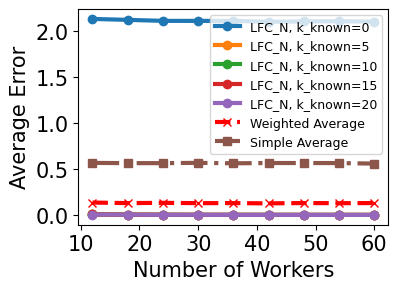

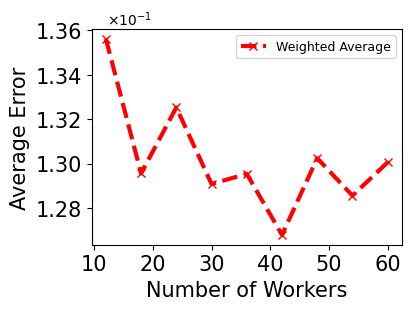

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform', 'uniform', 'uniform'] # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform':
            datas.append(np.random.uniform(6, 7, (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))

    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean

ms = [12, 18, 24, 30, 36, 42, 48, 54, 60]
known_values = [0,5,10,15,20]

known_values = [0, 5, 10, 15, 20]

plt.figure(figsize=(4, 2.8))

# Loop through known values and 'ms' for LFC_N method
for k_known in known_values:
    k = beta - k_known
    average_errors = []
    for m in ms:
        errors = []
        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(t, std_devs, m, k_known)
            error = LFC_N(data, known_data, m)
            errors.append(error)
        average_errors.append(np.mean(errors))
    plt.plot(ms, average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}',linewidth=line_width,markersize=marker_size)

# Compute errors for weighted_average, simple_average, and mode
weighted_average_errors = []
simple_average_errors = []
mode_errors = []
for m in ms:
    errors_weighted = []
    errors_simple = []
    errors_mode = []
    for _ in range(100):
        data = generate_data(mean, std_devs, m, 30)

        # Weighted average
        weighted_mean = weighted_average(data)
        errors_weighted.append((weighted_mean - mean)**2)

        # Simple average
        simple_mean = np.mean(data)
        errors_simple.append((simple_mean - mean)**2)

        # Mode
        flattened_data = data.flatten()
        mode = stats.mode(flattened_data).mode
        errors_mode.append((mode - mean)**2)

    weighted_average_errors.append(np.mean(errors_weighted))
    simple_average_errors.append(np.mean(errors_simple))
    mode_errors.append(np.mean(errors_mode))

# Plotting the errors for additional methods
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average',linewidth=line_width,markersize=marker_size, color='red')
plt.plot(ms, simple_average_errors, marker='s', linestyle='-.', label='Simple Average',linewidth=line_width,markersize=marker_size)

# Finalizing plot
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)

plt.savefig('/content/drive/MyDrive/实验图/图6a.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 2.8))
plt.plot(ms, weighted_average_errors, marker='x', linestyle='--', label='Weighted Average',linewidth=line_width,markersize=marker_size, color='red')
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.2f}".format(value*10)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-1}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图6b.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()

图6c

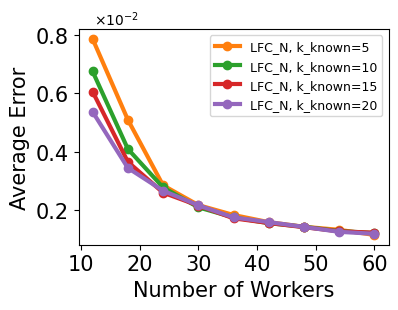

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform', 'uniform', 'uniform'] # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform':
            datas.append(np.random.uniform(6, 7, (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))

    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean

ms = [12, 18, 24, 30, 36, 42, 48, 54, 60]
known_values = [5, 10, 15, 20]



plt.figure(figsize=(4, 2.8))

# 定义颜色循环起始点
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
start_color_index = 1  # 从C1开始

# Loop through known values and 'ms' for LFC_N method
for i, k_known in enumerate(known_values):
    k = beta - k_known
    average_errors = []
    for m in ms:
        errors = []
        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(t, std_devs, m, k_known)
            error = LFC_N(data, known_data, m)
            errors.append(error)
        average_errors.append(np.mean(errors))
    color = color_cycle[(start_color_index + i) % len(color_cycle)]
    plt.plot(ms, average_errors, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}', linewidth=line_width, markersize=marker_size, color=color)



plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图6c.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



图7a仅仅有深思的恶意用户经过资格审查

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


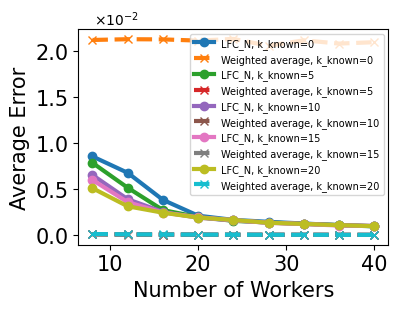

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform'] # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform':
            datas.append(np.random.uniform(6, 7, (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))

    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean
def wasserstein_distance(mean_est, var_est, mean_true, var_true):
    """Compute the Wasserstein distance."""
    distance = np.abs(mean_est - mean_true) + np.maximum(0, var_est - var_true)
    return distance

def qualification_assessment(known_data, h_true, q_true):
    """Apply the qualification assessment."""
    mean_estimates = np.mean(known_data, axis=1)
    variance_estimates = np.var(known_data, axis=1)
    distances = wasserstein_distance(mean_estimates, variance_estimates, h_true, q_true)
    average_distance = np.mean(distances)
    qualified_workers = distances < average_distance

    return qualified_workers

def weighted_average_with_qualification(data, known_data, h_true, q_true):
    """Compute the weighted average, considering qualification assessment."""
    qualified_workers = qualification_assessment(known_data, h_true, q_true)
    num_qualified_workers = np.sum(qualified_workers)
    #print(f"Number of workers passing the qualification: {num_qualified_workers}")

    # If no workers passed the assessment, use all data as a fallback
    if not np.any(qualified_workers):
        filtered_data = data
    else:
        filtered_data = data[qualified_workers]

    variances = np.var(filtered_data, axis=1)
    weights = 1 / (variances + 1e-10)  # Avoid division by zero
    means = np.mean(filtered_data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean


# --- Evaluation and Plotting ---

known_values = [0,5, 10, 15, 20]
ms = [8, 12, 16, 20, 24, 28, 32, 36, 40]
h_true = 5.0
q_true = 1.0

plt.figure(figsize=(4, 2.8))

for k_known in known_values:
    k = beta - k_known
    errors_weighted_qualification = []
    errors_simple = []
    errors_lfc = []

    for m in ms:
        errors_lfc_temp = []
        errors_weighted_temp = []
        errors_simple_temp = []

        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(h_true, std_devs, m, k_known)

            # LFC_N method
            error_lfc = LFC_N(data, known_data, m)
            errors_lfc_temp.append(error_lfc)

            # Weighted average with qualification
            weighted_mean_qualified = weighted_average_with_qualification(data, known_data, h_true, q_true)
            errors_weighted_temp.append((weighted_mean_qualified - mean)**2)

            # Simple average
            simple_mean = np.mean(data)
            errors_simple_temp.append((simple_mean - mean)**2)

        errors_weighted_qualification.append(np.mean(errors_weighted_temp))
        errors_simple.append(np.mean(errors_simple_temp))
        errors_lfc.append(np.mean(errors_lfc_temp))

    plt.plot(ms, errors_lfc, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}', linewidth=line_width, markersize=marker_size)
    plt.plot(ms, errors_weighted_qualification, marker='x', linestyle='--', label=f'Weighted average, k_known={k_known}', linewidth=line_width, markersize=marker_size)
    #plt.plot(ms, errors_simple, marker='s', linestyle='-.', label=f'Simple Average, k_known={k_known}')
legend_font_size = 7
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图7a.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

图7b

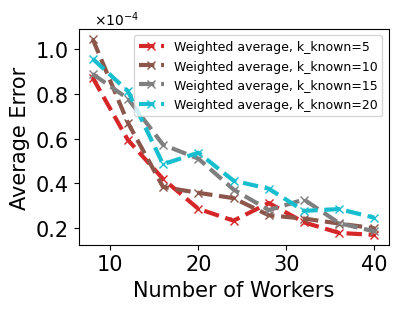

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ... [其他函数定义保持不变] ...

known_values = [5, 10, 15, 20]
ms = [8, 12, 16, 20, 24, 28, 32, 36, 40]

plt.figure(figsize=(4, 2.8))

# 获取颜色循环
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 为每个k_known选择特定的颜色
colors_for_known_values = {
    5: color_cycle[3],  # 例如，C4
    10: color_cycle[5],  # 例如，C6
    15: color_cycle[7],  # 例如，C8
    20: color_cycle[9],  # 例如，C10
}

for k_known in known_values:
    k = beta - k_known
    errors_weighted_qualification = []

    for m in ms:
        errors_weighted_temp = []

        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(h_true, std_devs, m, k_known)

            # Weighted average with qualification
            weighted_mean_qualified = weighted_average_with_qualification(data, known_data, h_true, q_true)
            errors_weighted_temp.append((weighted_mean_qualified - mean)**2)

        errors_weighted_qualification.append(np.mean(errors_weighted_temp))

    # 选择颜色
    color = colors_for_known_values[k_known]
    plt.plot(ms, errors_weighted_qualification, marker='x', linestyle='--', label=f'Weighted average, k_known={k_known}', color=color, linewidth=line_width, markersize=marker_size)
legend_font_size = 9
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*10000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-4}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图7b.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


图8有两类恶意用户都存在的情况，经过一次资格审查

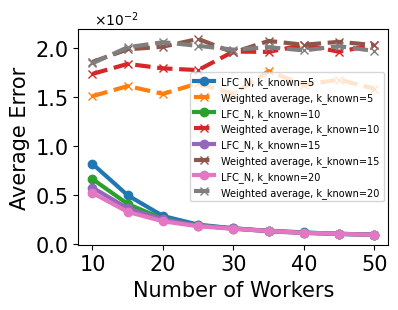

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform1','uniform2',] # Standard deviations for three user types

error_threshold = 0.0001


def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform1':
            datas.append(np.random.uniform(6, 7, (m_per_type, k)))
        elif std_dev == 'uniform2':
            datas.append(np.random.uniform(0, 10, (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))

    return np.concatenate(datas, axis=0)  # Concatenate along the user axis

def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean
def wasserstein_distance(mean_est, var_est, mean_true, var_true):
    """Compute the Wasserstein distance."""
    distance = np.abs(mean_est - mean_true) + np.maximum(0, var_est - var_true)
    return distance

def qualification_assessment(known_data, h_true, q_true):
    """Apply the qualification assessment."""
    mean_estimates = np.mean(known_data, axis=1)
    variance_estimates = np.var(known_data, axis=1)
    distances = wasserstein_distance(mean_estimates, variance_estimates, h_true, q_true)
    average_distance = np.mean(distances)
    qualified_workers = distances < average_distance

    return qualified_workers

def weighted_average_with_qualification(data, known_data, h_true, q_true):
    """Compute the weighted average, considering qualification assessment."""
    qualified_workers = qualification_assessment(known_data, h_true, q_true)

    num_qualified_workers = np.sum(qualified_workers)
    #print(f"Number of workers passing the qualification: {num_qualified_workers}")

    # If no workers passed the assessment, use all data as a fallback
    if not np.any(qualified_workers):
        filtered_data = data
    else:
        filtered_data = data[qualified_workers]

    variances = np.var(filtered_data, axis=1)
    weights = 1 / (variances + 1e-10)  # Avoid division by zero
    means = np.mean(filtered_data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean


# --- Evaluation and Plotting ---

known_values = [5, 10, 15, 20]
ms = [10, 15, 20, 25, 30, 35, 40, 45, 50]
h_true = 5.0
q_true = 1.0

plt.figure(figsize=(4, 2.8))

for k_known in known_values:
    k = beta - k_known
    errors_weighted_qualification = []
    errors_simple = []
    errors_lfc = []

    for m in ms:
        errors_lfc_temp = []
        errors_weighted_temp = []
        errors_simple_temp = []

        for _ in range(100):
            data = generate_data(mean, std_devs, m, k)
            known_data = generate_data(h_true, std_devs, m, k_known)

            # LFC_N method
            error_lfc = LFC_N(data, known_data, m)
            errors_lfc_temp.append(error_lfc)

            # Weighted average with qualification
            weighted_mean_qualified = weighted_average_with_qualification(data, known_data, h_true, q_true)
            errors_weighted_temp.append((weighted_mean_qualified - mean)**2)

            # Simple average
            simple_mean = np.mean(data)
            errors_simple_temp.append((simple_mean - mean)**2)

        errors_weighted_qualification.append(np.mean(errors_weighted_temp))
        errors_simple.append(np.mean(errors_simple_temp))
        errors_lfc.append(np.mean(errors_lfc_temp))

    plt.plot(ms, errors_lfc, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}',linewidth=line_width, markersize=marker_size)
    plt.plot(ms, errors_weighted_qualification, marker='x', linestyle='--', label=f'Weighted average, k_known={k_known}',linewidth=line_width, markersize=marker_size)
    #plt.plot(ms, errors_simple, marker='s', linestyle='-.', label=f'Simple Average, k_known={k_known}')

legend_font_size = 7
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图8.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()

图9两次资格审查的原因

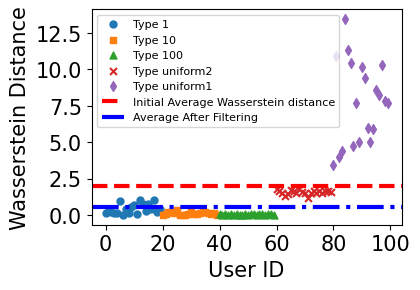

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
m = 100  # Total number of users
std_devs = [1, 10, 100, 'uniform2', 'uniform1']
h_true = 5.0
q_true = 1.0
mean = 5.0

# Constants for data collection
k = 5  # Number of times each user collects data

def generate_data_for_users(mean, std_devs, m, k):
    m_per_type = m // len(std_devs)
    datas = []
    for std_dev in std_devs:
        if std_dev == 'uniform1':
            datas.append(np.random.uniform(0, 10, (m_per_type, k)))
        elif std_dev == 'uniform2':
            datas.append(np.random.uniform(6, 7, (m_per_type, k)))
        else:
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))
    return np.concatenate(datas, axis=0)

def wasserstein_distance(mean_est, var_est, mean_true, var_true):
    """Compute the Wasserstein distance."""
    distance = np.abs(mean_est - mean_true) + np.maximum(0, var_est - var_true)
    return distance

def wasserstein_distance_for_users(data, h_true, q_true):
    mean_estimates = np.mean(data, axis=1)
    variance_estimates = np.var(data, axis=1)
    distances = wasserstein_distance(mean_estimates, variance_estimates, h_true, q_true)
    return distances

data = generate_data_for_users(mean, std_devs, m, k)
distances = wasserstein_distance_for_users(data, h_true, q_true)
filtered_data = data[distances < np.mean(distances)]
filtered_distances = wasserstein_distance_for_users(filtered_data, h_true, q_true)
avg_distance_after_filtering = np.mean(filtered_distances)

# Plotting the Wasserstein distances
plt.figure(figsize=(4, 2.8))

# Different markers for different user types
markers = ['o', 's', '^', 'x', 'd']
for i in range(5):
    start_idx = (m // 5) * i
    end_idx = (m // 5) * (i + 1)
    plt.scatter(range(start_idx, end_idx), distances[start_idx:end_idx], label=f'Type {std_devs[i]}', marker=markers[i],s=25)

# Plotting the initial average line
plt.axhline(np.mean(distances), color='r', linestyle='--', label='Initial Average Wasserstein distance',linewidth=line_width, markersize=3)

# Plotting the average line after filtering
plt.axhline(avg_distance_after_filtering, color='b', linestyle='-.', label='Average After Filtering',linewidth=line_width, markersize=3)
legend_font_size = 8
plt.xlabel('User ID',fontsize=label_font_size)
plt.ylabel('Wasserstein Distance', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
plt.savefig('/content/drive/MyDrive/实验图/图9.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()


图10仅两类恶意用户经过两次资格审查后

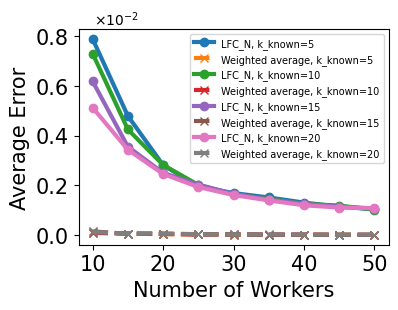

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools
# Constants
beta = 60
t = 5.0  # True value for known data
mean = 5.0
std_devs = [1, 10, 100, 'uniform1','uniform2',] # Standard deviations for three user types
error_threshold = 0.0001

def generate_data(mean, std_devs, m, k):
    """Generate random data for given parameters."""
    m_per_type = m // len(std_devs)  # Number of users per type
    datas = []
    type_indices = {}
    start_index = 0
    for std_dev in std_devs:
        end_index = start_index + m_per_type
        if std_dev in ['uniform1', 'uniform2']:
            datas.append(np.random.uniform(6, 7, (m_per_type, k)))
        else:  # For normal distributions
            datas.append(np.random.normal(mean, (1/std_dev)**0.5, (m_per_type, k)))
        type_indices[std_dev] = list(range(start_index, end_index))
        start_index = end_index

    return np.concatenate(datas, axis=0), type_indices


def compute_new_values(data, known_data, t, user_qualities, beta):
    """Compute new values for tasks and user qualities."""
    if np.sum(user_qualities) == 0:
        user_qualities += 1e-10  # Add a small value to avoid division by zero

    # Ensure that the shapes are compatible for multiplication
    estimated_task_values = np.sum(data * user_qualities[:, np.newaxis], axis=0) / np.sum(user_qualities)

    diff_unknown = data - estimated_task_values
    diff_known = known_data - t
    new_user_qualities = ((np.sum(diff_unknown ** 2, axis=1) + np.sum(diff_known ** 2, axis=1)) / beta)

    # Avoid division by zero
    new_user_qualities = np.clip(new_user_qualities, 1e-10, None)  # Replace zeros with a small value
    new_user_qualities = 1 / new_user_qualities
    return estimated_task_values, new_user_qualities


def LFC_N(data, known_data, m):
    task_values = np.ones(k)  # Initialize task values to 1
    user_qualities = np.ones(m)  # Initialize user qualities to 1

    while True:
        new_task_values, new_user_qualities = compute_new_values(data, known_data, t, user_qualities, beta)

        # Compute errors
        task_values_error = np.sum(new_task_values - task_values)**2

        # Update user_qualities and task_values
        user_qualities = new_user_qualities
        task_values = new_task_values

        # Check for stopping condition
        if  task_values_error < error_threshold:
            break

    return np.mean((task_values - t)**2)

def weighted_average(data):
    """Computes the weighted average of the data using the inverse of the variance as weights."""
    variances = np.var(data, axis=1)
    weights = 1 / (variances + 1e-10)  # Add a small constant to avoid division by zero
    means = np.mean(data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean
def wasserstein_distance(mean_est, var_est, mean_true, var_true):
    """Compute the Wasserstein distance."""
    distance = np.abs(mean_est - mean_true) + np.maximum(0, var_est - var_true)
    return distance

def qualification_assessment(known_data, h_true, q_true, normal_indices):
    """Apply the qualification assessment."""
    mean_estimates = np.mean(known_data, axis=1)
    variance_estimates = np.var(known_data, axis=1)
    distances = wasserstein_distance(mean_estimates, variance_estimates, h_true, q_true)

    # First average
    average_distance = np.mean(distances)

    # Filter based on the first average
    qualified_workers = distances < average_distance

    # Second average
    new_avg_distance = np.mean(distances[qualified_workers])

    # Update qualified workers based on the new average
    qualified_workers = distances < new_avg_distance

    disqualified_normal_workers = sum([not qualified_workers[i] for i in normal_indices])
    total_normal_workers = len(normal_indices)
    #print(f"Percentage of disqualified normal workers: {100 * disqualified_normal_workers / total_normal_workers:.2f}%")

    return qualified_workers

def weighted_average_with_qualification(data, known_data, h_true, q_true, normal_indices):

    """Compute the weighted average, considering qualification assessment."""
    qualified_workers = qualification_assessment(known_data, h_true, q_true, normal_indices)


    num_qualified_workers = np.sum(qualified_workers)
    #print(f"Number of workers passing the qualification: {num_qualified_workers}")

    # If no workers passed the assessment, use all data as a fallback
    if not np.any(qualified_workers):
        filtered_data = data
    else:
        filtered_data = data[qualified_workers]

    variances = np.var(filtered_data, axis=1)
    weights = 1 / (variances + 1e-10)  # Avoid division by zero
    means = np.mean(filtered_data, axis=1)
    weighted_mean = np.average(means, weights=weights)
    return weighted_mean


# --- Evaluation and Plotting ---

known_values = [5, 10, 15, 20]
ms = [10, 15, 20, 25, 30, 35, 40, 45, 50]
h_true = 5.0
q_true = 1

plt.figure(figsize=(4, 2.8))

for k_known in known_values:
    k = beta - k_known
    errors_weighted_qualification = []
    errors_simple = []
    errors_lfc = []

    for m in ms:
        errors_lfc_temp = []
        errors_weighted_temp = []
        errors_simple_temp = []

        for _ in range(100):
            data, data_indices = generate_data(mean, std_devs, m, k)
            known_data, _ = generate_data(h_true, std_devs, m, k_known)


            # LFC_N method
            error_lfc = LFC_N(data, known_data, m)
            errors_lfc_temp.append(error_lfc)

            # Weighted average with qualification
            normal_indices = list(itertools.chain.from_iterable(data_indices[std_dev] for std_dev in [1, 10, 100]))
            weighted_mean_qualified = weighted_average_with_qualification(data, known_data, h_true, q_true, normal_indices)

            errors_weighted_temp.append((weighted_mean_qualified - mean)**2)

            # Simple average
            simple_mean = np.mean(data)
            errors_simple_temp.append((simple_mean - mean)**2)

        errors_weighted_qualification.append(np.mean(errors_weighted_temp))
        errors_simple.append(np.mean(errors_simple_temp))
        errors_lfc.append(np.mean(errors_lfc_temp))

    plt.plot(ms, errors_lfc, marker='o', linestyle='-', label=f'LFC_N, k_known={k_known}',linewidth=line_width, markersize=marker_size)
    plt.plot(ms, errors_weighted_qualification, marker='x', linestyle='--', label=f'Weighted average, k_known={k_known}',linewidth=line_width, markersize=marker_size)
    #plt.plot(ms, errors_simple, marker='s', linestyle='-.', label=f'Simple Average, k_known={k_known}')
legend_font_size = 7
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*100)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-2}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图10a.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()

图10b

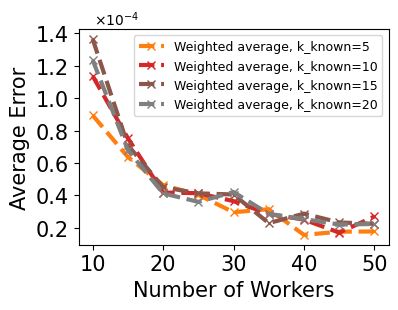

In [102]:
known_values = [5, 10, 15, 20]
ms = [10, 15, 20, 25, 30, 35, 40, 45, 50]
h_true = 5.0
q_true = 1

plt.figure(figsize=(4, 2.8))

# 获取颜色循环
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 为每个k_known选择特定的颜色
colors_for_known_values = {
    5: color_cycle[1],  # 例如，C4
    10: color_cycle[3],  # 例如，C6
    15: color_cycle[5],  # 例如，C8
    20: color_cycle[7],  # 例如，C10
}

for k_known in known_values:
    k = beta - k_known
    errors_weighted_qualification = []
    errors_simple = []
    errors_lfc = []

    for m in ms:
        errors_lfc_temp = []
        errors_weighted_temp = []
        errors_simple_temp = []

        for _ in range(100):
            data, data_indices = generate_data(mean, std_devs, m, k)
            known_data, _ = generate_data(h_true, std_devs, m, k_known)


            # LFC_N method
            error_lfc = LFC_N(data, known_data, m)
            errors_lfc_temp.append(error_lfc)

            # Weighted average with qualification
            normal_indices = list(itertools.chain.from_iterable(data_indices[std_dev] for std_dev in [1, 10, 100]))
            weighted_mean_qualified = weighted_average_with_qualification(data, known_data, h_true, q_true, normal_indices)

            errors_weighted_temp.append((weighted_mean_qualified - mean)**2)

            # Simple average
            simple_mean = np.mean(data)
            errors_simple_temp.append((simple_mean - mean)**2)

        errors_weighted_qualification.append(np.mean(errors_weighted_temp))
        errors_simple.append(np.mean(errors_simple_temp))
        errors_lfc.append(np.mean(errors_lfc_temp))

    color = colors_for_known_values[k_known]
    plt.plot(ms, errors_weighted_qualification, marker='x', linestyle='--', label=f'Weighted average, k_known={k_known}', color=color, linewidth=line_width, markersize=marker_size)
legend_font_size = 9
plt.xlabel('Number of Workers', fontsize=label_font_size)
plt.ylabel('Average Error', fontsize=label_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.legend(fontsize=legend_font_size)
def custom_formatter(value, pos):
    return "{:.1f}".format(value*10000)
formatter = mticker.FuncFormatter(custom_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().annotate('$\\times10^{-4}$', xy=(0.05, 1.05), xycoords='axes fraction',
                   fontsize=10, ha='left', va='center')
plt.savefig('/content/drive/MyDrive/实验图/图10b.pdf', format='pdf',dpi=300, bbox_inches='tight')
plt.show()